<a href="https://colab.research.google.com/github/Binit17/tensorflow-tutorials/blob/main/BasicTextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Text Classification

In [4]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import losses
#instead of from tensorflow.keras import layers
#instead of from tensorflow.keras import losses

In [5]:
print(tf.__version__)

2.15.0


#Sentiment analysis
This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the Large Movie Review Dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

Let's download and extract the dataset, then explore the directory structure.


In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 14s 0us/step


url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz": Defines the URL from which the dataset will be downloaded. This URL points to a tar.gz file containing the IMDB movie review dataset.

dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir=''): This line downloads the dataset specified by the URL and extracts it. The function tf.keras.utils.get_file downloads a file from the specified URL and caches it locally. The parameters used here are:

"aclImdb_v1": The name under which the file will be saved locally.

url: The URL of the file to download.

untar=True: Indicates that the downloaded file should be extracted (since it's a tar.gz file).

cache_dir='.': Specifies the directory where the downloaded file will be cached. In this case, '.' refers to the current directory.

cache_subdir='': Specifies the subdirectory within the cache directory where the downloaded file will be saved. Since it's an empty string, it means the file will be saved directly in the cache directory without any additional subdirectory.

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb'): This line constructs the directory path where the extracted dataset will be located. It uses os.path.dirname() to get the directory where the downloaded file is stored (which is returned by tf.keras.utils.get_file), then it appends the directory name 'aclImdb' to it using os.path.join().

In [7]:
os.listdir(dataset_dir)

['imdb.vocab', 'README', 'test', 'train', 'imdbEr.txt']

In [8]:
train_dir = os.path.join(dataset_dir,'train')

In [9]:
os.listdir(train_dir)

['labeledBow.feat',
 'unsup',
 'neg',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_unsup.txt',
 'pos',
 'urls_pos.txt']

# Load the dataset
Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful text_dataset_from_directory utility, which expects a directory structure as follows.

main_directory/

...class_a/

......a_text_1.txt

......a_text_2.txt

...class_b/

......b_text_1.txt

......b_text_2.txt

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to class_a and class_b. These will be the positive and negative movie reviews, which can be found in aclImdb/train/pos and aclImdb/train/neg. As the IMDB dataset contains additional folders, you will remove them before using this utility.



In [10]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

Next, you will use the **text_dataset_from_directory **utility to create a labeled **tf.data.Dataset**. **tf.data** is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: **train, validation, and test.**

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an **80:20 split of the training data **by using the validation_split argument below.

In [20]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.



So, in summary, batch_size controls the size of each batch in the dataset, and seed ensures that the shuffling of the dataset is consistent across different runs of the code.

As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to model.fit.

### Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

In [19]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


#Prepare the dataset for training
Next, you will standardize, tokenize, and vectorize the data using the helpful tf.keras.layers.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

In [14]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a TextVectorization layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the output_mode to int to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [16]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [17]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

#Configure the dataset for performance
These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Create the model
It's time to create your neural network:

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
________________

The layers are stacked sequentially to build the classifier:

The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, check out the Word embeddings tutorial.


Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
The last layer is densely connected with a single output node.


##Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use losses.BinaryCrossentropy loss function.

Now, configure the model to use an optimizer and a loss function:

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

#Train the model
You will train the model by passing the dataset object to the fit method.

In [26]:
epochs =10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
625/625 [==============================] - 12s 17ms/step - loss: 0.6637 - binary_accuracy: 0.6937 - val_loss: 0.6137 - val_binary_accuracy: 0.7734
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 0.5474 - binary_accuracy: 0.8017 - val_loss: 0.4962 - val_binary_accuracy: 0.8228
Epoch 3/10
625/625 [==============================] - 6s 9ms/step - loss: 0.4443 - binary_accuracy: 0.8447 - val_loss: 0.4185 - val_binary_accuracy: 0.8478
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3788 - binary_accuracy: 0.8666 - val_loss: 0.3724 - val_binary_accuracy: 0.8624
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3368 - binary_accuracy: 0.8776 - val_loss: 0.3440 - val_binary_accuracy: 0.8680
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3069 - binary_accuracy: 0.8877 - val_loss: 0.3247 - val_binary_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 7s 11

#Evaluate the model
Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 7s 9ms/step - loss: 0.3102 - binary_accuracy: 0.8727
Loss:  0.3101626932621002
Accuracy:  0.8727200031280518


##Create a plot of accuracy and loss over time
model.fit() returns a History object that contains a dictionary with everything that happened during training:


In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

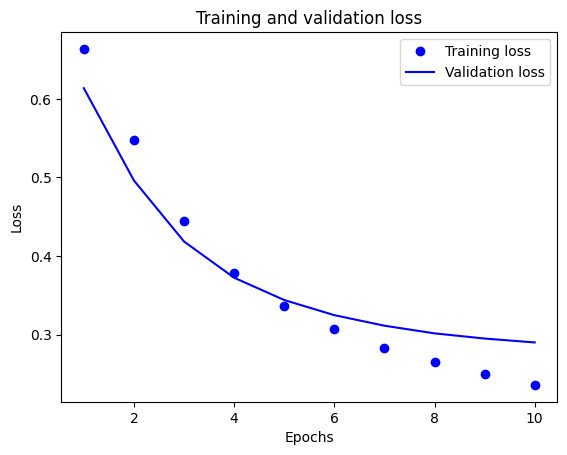

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

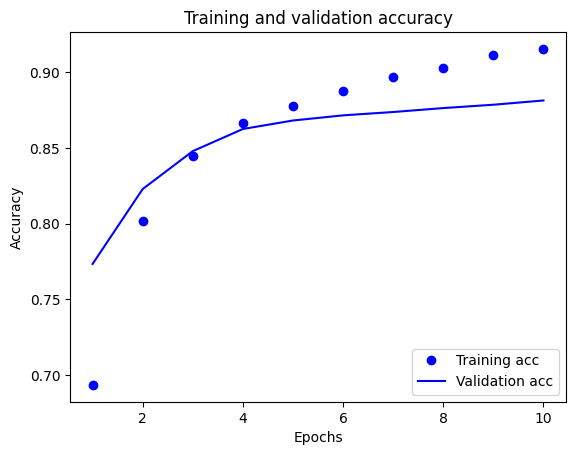

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()